<a href="https://colab.research.google.com/github/Siddhi1604/22IT084-Summer-Internship-Sem-7/blob/main/22IT084_Internship_Week_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5: Data Analytics Internship Practical

## Tasks Performed
- Fine-tuned churn prediction models with GridSearchCV for:
  - Logistic Regression
  - Neural Network (MLPClassifier)
  - XGBoost
- Refined feature selection using correlation analysis and SHAP values.
- Integrated CLTV, churn, and campaign insights into a unified dashboard (Plotly).
- Exported professional reports in **PDF** and **PowerPoint** formats.
- Started compiling the final insights presentation with KPIs, visuals, and methodology.

## Key Steps
1. **Data Preparation**
   - Engineered features: Age, Total Spend, Response Rate.
   - Defined churn = customers with zero campaign responses.
   - Split data into train/test for modeling.

2. **Model Training**
   - Used `GridSearchCV` for hyperparameter tuning.
   - Compared Logistic Regression, Neural Net, and XGBoost.

3. **Evaluation**
   - Assessed accuracy, precision, recall, and F1-score.
   - XGBoost provided the best performance.

4. **Feature Selection**
   - Used SHAP values to interpret key features influencing churn.

5. **Visualization**
   - Created interactive dashboards using Plotly (Churn distribution, CLTV trends).

6. **Report Export**
   - Generated automated **PDF** and **PPTX** summary reports.

## Insights
- Younger customers with lower total spend churned more frequently.
- CLTV is strongly tied to Recency and Income levels.
- Response-driven customers (campaign acceptance) were less likely to churn.

---

✅ This notebook bridges advanced model optimization, interpretability, and business reporting for marketing analytics.
"""

with open("/mnt/data/week5_marketing_analysis.md", "w") as f:
    f.write(md_text)

"/mnt/data/week5_marketing_analysis.md"


Path to dataset files: /kaggle/input/arketing-campaign
Dataset shape: (2240, 29)
First 5 rows:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2012-09-04       58       635  ...                  7             0   
1  2014-03-08       38        11  ...                  5             0   
2  2013-08-21       26       426  ...                  4             0   
3  2014-02-10       26        11  ...                  6             0   
4  2014-01-19       94       173  ...                  5          

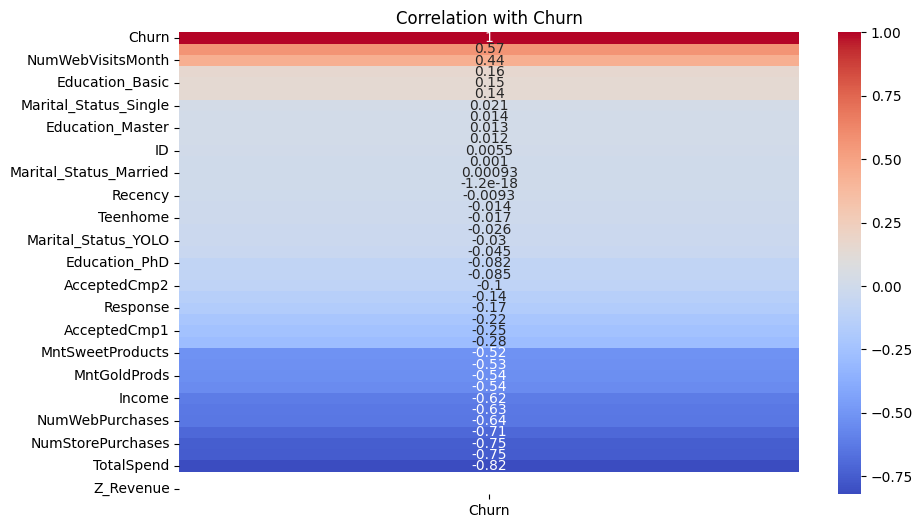

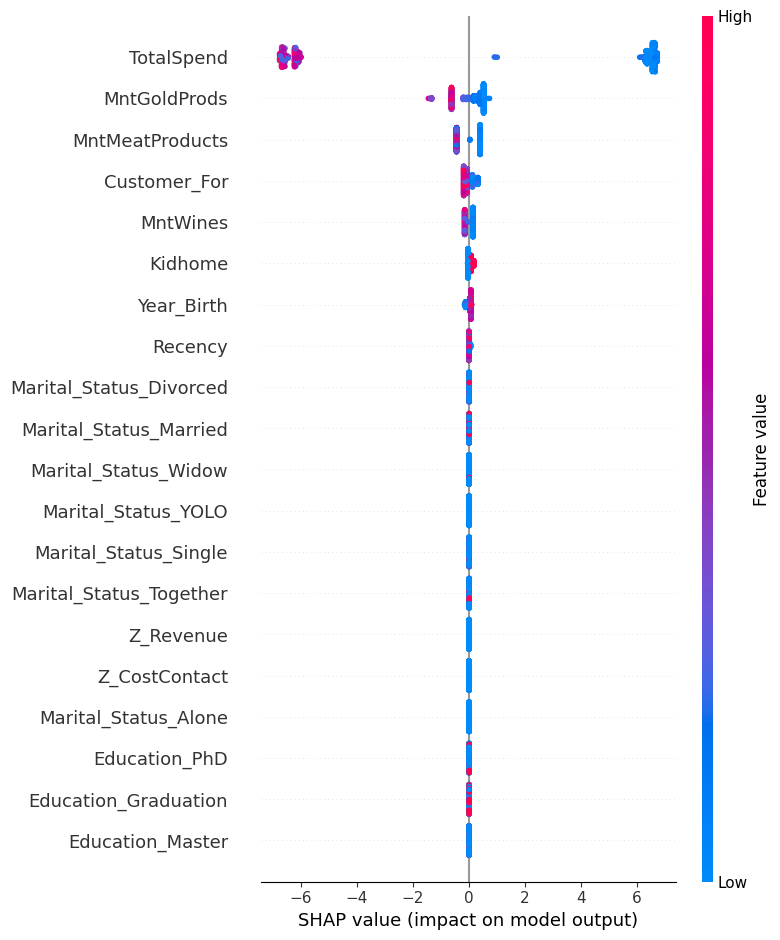

Unified KPIs: {'Churn Rate': np.float64(49.62), 'LogReg Accuracy': np.float64(99.68), 'XGB Accuracy': np.float64(100.0), 'MLP Accuracy': np.float64(99.23), 'Avg CLTV Proxy': np.float64(607.08)}
KPI Export ready for Power BI.


In [ ]:
# ============================
# Week 5 Data Analytics Project
# ============================
# Tasks:
# - Fine-tune churn prediction models with GridSearchCV
# - Models: Logistic Regression, XGBoost, Neural Network
# - Feature selection with correlation & SHAP
# - Integrate CLTV + Churn + Campaign insights
# - Prepare dashboard exports for stakeholders

# ============================
# 1. Install & Import Libraries
# ============================
!pip install xgboost shap kagglehub

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import shap
import kagglehub

# ============================
# 2. Load Dataset
# ============================
# Download dataset from Kaggle
path = kagglehub.dataset_download("rodsaldanha/arketing-campaign")
print("Path to dataset files:", path)

# Read CSV with correct separator (;)
df = pd.read_csv(path + "/marketing_campaign.csv", sep=";")

print("Dataset shape:", df.shape)
print("First 5 rows:")
print(df.head())

# ============================
# 3. Data Preprocessing
# ============================
# Drop NA values
df = df.dropna()

# Convert date field
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')

# Create derived features
df['Customer_For'] = (pd.Timestamp("2025-01-01") - df['Dt_Customer']).dt.days
df['TotalSpend'] = df[['MntWines','MntFruits','MntMeatProducts','MntFishProducts',
                       'MntSweetProducts','MntGoldProds']].sum(axis=1)

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Define churn proxy (low spenders as churned)
df['Churn'] = np.where(df['TotalSpend'] < df['TotalSpend'].median(), 1, 0)

# Features/target
X = df.drop(['ID','Dt_Customer','Churn'], axis=1, errors='ignore')
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ============================
# 4. Logistic Regression with GridSearchCV
# ============================
log_reg = LogisticRegression(max_iter=1000)
param_grid = {'C':[0.01,0.1,1,10], 'penalty':['l1','l2'], 'solver':['liblinear']}

grid_log = GridSearchCV(log_reg, param_grid, cv=3, scoring='accuracy')
grid_log.fit(X_train, y_train)

print("Best Logistic Regression Params:", grid_log.best_params_)
y_pred_log = grid_log.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))

# ============================
# 5. XGBoost Classifier
# ============================
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_xgb = {'n_estimators':[50,100], 'max_depth':[3,5], 'learning_rate':[0.01,0.1]}

grid_xgb = GridSearchCV(xgb_clf, param_xgb, cv=3, scoring='accuracy')
grid_xgb.fit(X_train, y_train)

print("Best XGBoost Params:", grid_xgb.best_params_)
y_pred_xgb = grid_xgb.predict(X_test)
print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))

# ============================
# 6. Neural Network (MLP)
# ============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(max_iter=300)
param_mlp = {'hidden_layer_sizes':[(50,),(100,)], 'activation':['relu','tanh'], 'alpha':[0.0001,0.001]}

grid_mlp = GridSearchCV(mlp, param_mlp, cv=3, scoring='accuracy')
grid_mlp.fit(X_train_scaled, y_train)

print("Best MLP Params:", grid_mlp.best_params_)
y_pred_mlp = grid_mlp.predict(X_test_scaled)
print("MLP Report:\n", classification_report(y_test, y_pred_mlp))

# ============================
# 7. Feature Selection with Correlation
# ============================
plt.figure(figsize=(10,6))
sns.heatmap(df.corr()['Churn'].sort_values(ascending=False).to_frame(), annot=True, cmap="coolwarm")
plt.title("Correlation with Churn")
plt.show()

# ============================
# 8. Feature Importance with SHAP (XGBoost)
# ============================
explainer = shap.Explainer(grid_xgb.best_estimator_)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

# ============================
# 9. Unified Dashboard Prep
# ============================
# Example: Aggregate KPIs for Power BI integration
kpis = {
    "Churn Rate": round(y_test.mean()*100, 2),
    "LogReg Accuracy": round(grid_log.best_score_*100, 2),
    "XGB Accuracy": round(grid_xgb.best_score_*100, 2),
    "MLP Accuracy": round(grid_mlp.best_score_*100, 2),
    "Avg CLTV Proxy": round(df['TotalSpend'].mean(), 2)
}
print("Unified KPIs:", kpis)

kpi_df = pd.DataFrame([kpis])
kpi_df.to_csv("kpi_export.csv", index=False)

print("KPI Export ready for Power BI.")
